# Self-Organizing Maps (SOMs) Figure Notebook
- **Make composite and anomalies maps for all SOM nodes from "winning" SOM**
- Notebook by Alice DuVivier (NCAR) and Maria Molina (UMd)
- November 2022

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import seaborn as sns
import dask
import utils
import cmocean

In [2]:
# set the location of the already extracted training data
sector_short = 'Ross'
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/'+sector_short+'_analysis_v3/'
path_out = path_in+'figures_outline/'

### Specify variables to plot

In [3]:
# set path to the pulled data
# Note data is for larger area than only training points
# this data has been processed all the same 'time' coordinates as training data
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'

# set what variables we can plot
vars_composite_in = ['dvidtd_d', 'dvidtt_d']


In [21]:
# USER CHOOSE WHICH VARIABLE TO PLOT: 0-1
n = 1
var_composite_in = vars_composite_in[n] 

In [22]:
# file name for training variable only here 
fin_composite = 'antarctic_data_for_som_composites_'+var_composite_in

In [23]:
# load data
ds = xr.open_mfdataset(data_path_in+fin_composite+'.nc')

In [24]:
data = ds.data.where((ds.TLON > 140.0) & (ds.TLON < 230.0) & (ds.TLAT < -68.0))

In [25]:
# explicitly load data so that it doesn't take forever later on during mean
data = data.load()

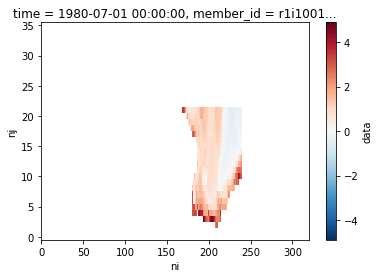

In [26]:
data.isel(training_times=0).plot()

## Calculate the mean for all winter by decade

In [27]:
# calculate winter mean against which to do anomalies
data_mean = data.mean(dim='training_times')

In [28]:
decade_names = ['1980','1990', '2000', '2010', '2020', '2030', '2040', '2050', '2060', '2070']

In [29]:
# make numpy array to fill and specify dimensions we want
decade_array = np.zeros([len(decade_names),len(data_mean.nj),len(data_mean.ni)])

for dd in decade_names:
    print('decade: '+dd+'s')
    if dd == '1980':
        d_count = 0
        yy_st = 1980
    else: 
        d_count = d_count+1
        yy_st = yy_st + 10
    # get years for this decade
    yy_ed = yy_st + 10
    yy_all = list(range(yy_st,yy_ed,1))
    # get mean for this decade
    decade_array[d_count,:,:]   = data.isel(training_times=data.time.dt.year.isin([yy_all])).mean(dim='training_times')
    

decade: 1980s
decade: 1990s
decade: 2000s
decade: 2010s
decade: 2020s
decade: 2030s
decade: 2040s
decade: 2050s
decade: 2060s
decade: 2070s


In [30]:
print(decade_array.shape)

(10, 36, 320)


In [31]:
# convert the numpy array to a xarray for easier plotting
decade_means = xr.DataArray(decade_array,dims=('decade','nj','ni'))

In [32]:
# set coordinate arrays
decade_means['decade'] = decade_names
decade_means['nj'] = data_mean['nj'].values
decade_means['ni'] = data_mean['ni'].values

## Plot decadal mean differences

In [33]:
# Set plotting limits
lat_max = -72
lat_min = -80
lon_max = 200
lon_min = 160
lon_avg = 190

In [36]:
# set some labeling things
units = '(cm/day)'

# set limits
if var_composite_in == 'dvidtd_d':
    print(var_composite_in)
    title_in = 'Volume Tendency - dynamics\n'
    # node average info
    levels_in = np.arange(-8,8.5,0.5)
    ticks_in = [-8,-6,-4,-2,0,2,4,6,8]
    cmap_in = cmocean.cm.curl
    # node anomaly info
    levels_diff = np.arange(-2,2.2,0.2)
    ticks_diff = [-2,-1,0,1,2]
    cmap_diff = cmocean.cm.diff
    # prefixes
    pref_1 = 'a) '
    pref_2 = 'b) '
    pref_3 = 'c) '
if var_composite_in == 'dvidtt_d':
    print(var_composite_in)
    title_in = 'Volume Tendency - thermodynamics\n'
    # node average info
    levels_in = np.arange(-6,6.5,0.5)
    ticks_in = [-6,-4,-2,0,2,4,6]
    cmap_in = cmocean.cm.curl
    # node anomaly info
    levels_diff = np.arange(-2,2.2,0.2)
    ticks_diff = [-2,-1,0,1,2]
    cmap_diff = cmocean.cm.diff  
    # prefixes
    pref_1 = 'd) '
    pref_2 = 'e) '
    pref_3 = 'f) '


dvidtt_d


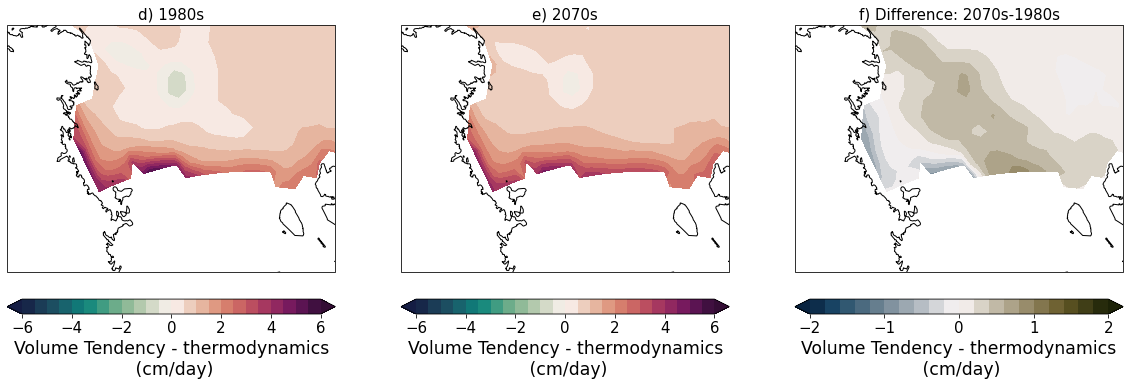

In [37]:
## 2070's difference figure
tag = '2070'

# select data
data_ctrl = decade_means.sel(decade='1980')
data_in = decade_means.sel(decade=tag)
data_diff = data_in - data_ctrl

# create figure
fig = plt.figure(figsize=(20,10))
fout = path_out+'supp_fig16_decadal_'+var_composite_in

# get lats/lons for plotting
lons = ds.TLON
lats = ds.TLAT

# plot the subplots - note it's nrow x ncol x index (starting upper left)
### mean over 1980s
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
plt.title(pref_1+'1980s',fontsize=15)

### mean future
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
plt.title(pref_2+tag+'s',fontsize=15)

### diff
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                     data_diff,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
plt.title(pref_3+'Difference: '+tag+'s-1980s',fontsize=15)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)